In [1]:
import csv
from matplotlib import pyplot as plt
import numpy as np
from scipy.misc import imread
import pickle
import cv2
from sklearn import linear_model
import seaborn as sns
import warnings
from jupyterthemes import jtplot

In [2]:
%matplotlib inline
jtplot.style()
sns.set_context("poster")
warnings.filterwarnings("ignore")

In [5]:
with open('data/warehouse_original_setup.pkl', 'rb') as f:
    data = pickle.load(f)

In [36]:
X_train = data['images']
XX_train = np.array([(.15,0)]* len(X_train))
y_train = np.array([x[0] for x in data['steering_throttle']])

#clean up the beginning and the end of the clip
data_frames_to_drop = [(0,500), (-900, -1)]
clean_indicies = np.ones(len(X_train))
for r in data_frames_to_drop:
    clean_indicies[r[0]:r[1]] = 0

X_train = X_train[clean_indicies.astype(np.bool)]
XX_train = XX_train[clean_indicies.astype(np.bool)]
y_train = y_train[clean_indicies.astype(np.bool)]
S_train = np.arange(len(y_train) )

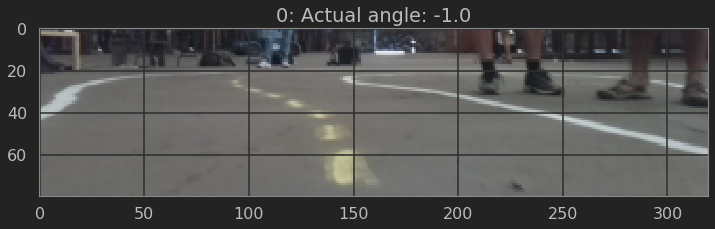

In [25]:
frame_id = 0
img = X_train[0]
plt.figure(figsize=(12,7))
plt.title("{}: Actual angle: {}".format(frame_id, round(y_train[frame_id] * 45, 3)))
plt.imshow(img)


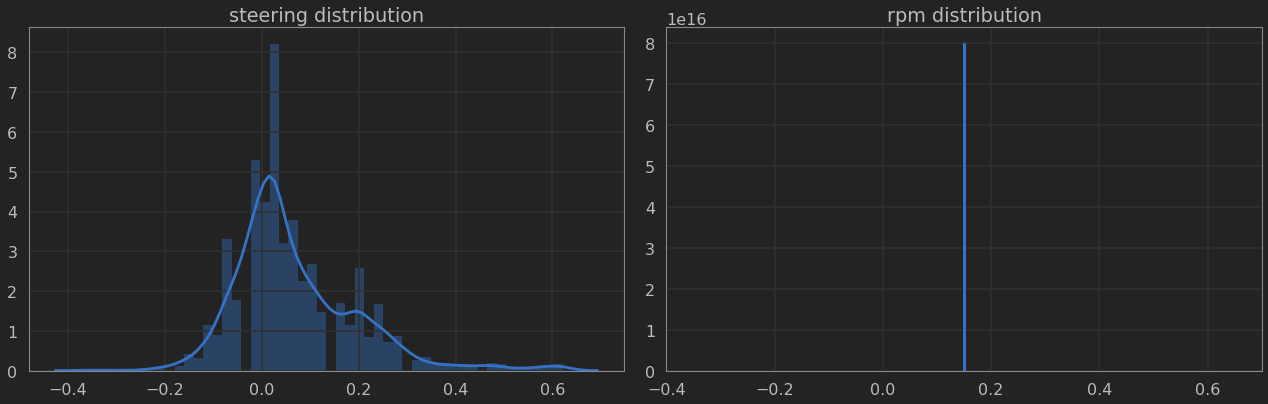

In [27]:
plt.figure(figsize=(18,6))
plt.subplot(1,2,1)
plt.title("steering distribution")
sns.distplot(y_train)
plt.subplot(1,2,2)
plt.title("rpm distribution")
sns.distplot(XX_train[:,0])
plt.tight_layout()

In [28]:
frame_id = 19

In [38]:
xx_train = [] #images
yy_train = [] #actual steering
ss_train = [] #sensors

for current_frame_index in range(len(X_train) - 90):
    frame_start = S_train[current_frame_index]
    frame_end = frame_start + 90
    working_index = current_frame_index
    steering_angles_actual = [y_train[current_frame_index]]
    
    for ii in range(3,90, 3):
        next_img_index = frame_start + ii
        #keep track of the last considered index so in case in exact match is not 
        #found, we have both the index greater and smaller than the desired index
        #and we can fit a line
        last_considered_index = 0
        while S_train[working_index] < next_img_index:
            last_considered_index = working_index
            working_index += 1

        if S_train[working_index] == next_img_index:
            steering_angles_actual.append(y_train[working_index])
        else:
            # fit a linear model between the two points and interpolate the value
            y_1, y_2 = y_train[last_considered_index], y_train[working_index]
            x_1, x_2 = S_train[last_considered_index], S_train[working_index]

            regr = linear_model.LinearRegression()
            regr.fit(np.array([x_1, x_2]).reshape(-1, 1), 
                     np.array([y_1, y_2]).reshape(-1, 1))
            y_interpolated = regr.predict(next_img_index)
            steering_angles_actual.append(y_interpolated[0])

    xx_train.append(X_train[current_frame_index])
    ss_train.append(XX_train[current_frame_index])
    yy_train.append(steering_angles_actual) 
        
yy_train = np.array(yy_train).reshape(-1,30)
xx_train = xx_train
ss_train = np.array(ss_train)

In [39]:
frame=0
def display_frame(frame_id):
    plt.figure(figsize=(18,6))
    plt.subplot(222)
    plt.title("{} - ACTUAL: {}°".format(
        frame_id,
        round(yy_train[frame_id][0] * 45,3)))
    plt.imshow(xx_train[frame_id])
    
    plt.subplot(224)
    plt.title("Frames to scrub")
    plt.ylim(0,50)
    plt.imshow(np.tile(frames_to_remove,(50,1)), cmap="OrRd")
    
    plt.subplot(121)
    plt.plot(yy_train[frame_id] * 45,np.arange(0,90,3), label="actual angle")
    plt.ylim((0,90))
    plt.xlim((-45,45)) 
    plt.legend()
    plt.tight_layout()
    plt.show()


In [42]:
#scrub through thismanually for bad frames.... ouch time consuming
from ipywidgets import interact, interactive, fixed, interact_manual, Layout
import ipywidgets as widgets


total_frames = len(xx_train) - 1
frames_to_remove = np.zeros(len(xx_train))

#frame selection
play = widgets.Play(
#     interval=10,
    value=0,
    min=0,
    max=total_frames,
    interval=600,
    step=5,
    description="Play",
    disabled=False
)
frame_selection_slider = widgets.IntSlider(min=0,max=total_frames,step=1,value=0, 
    continuous_update=False,
    layout=Layout(width="100%"))
frame_selection_text = widgets.Text(layout=Layout(width="100px"))
widgets.jslink((frame_selection_slider, 'value'), (frame_selection_text, 'value'))
widgets.jslink((frame_selection_slider, 'value'), (play, 'value'))

#mark bad frames
mark_bad_range = widgets.IntRangeSlider(
    value=[0, 0],
    min=0,
    max=total_frames,
    step=1,
    description='Bad Frames:',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='d',
    layout=Layout(width="100%")
)

def on_bad_range_click(btn):
    start, finish = mark_bad_range.value
    frames_to_remove[start:finish] = 1
    output.layout.height = '450px'
    interactive_plot.update()
    
add_bad_frames_btn = widgets.Button(
    description='Add range of bad frames',
    disabled=False,
    button_style='danger',
    tooltip='Click me',
    icon='delete'
)
add_bad_frames_btn.on_click(on_bad_range_click)
interactive_plot = interactive(display_frame, frame_id=frame_selection_slider)
output = interactive_plot.children[-1]
output.layout.height = '450px'

def display_scrubber():
    display(widgets.HBox([play, frame_selection_text,add_bad_frames_btn ]),
            mark_bad_range,interactive_plot )
display_scrubber()

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

In [50]:
xx_train.shape

AttributeError: 'list' object has no attribute 'shape'

In [51]:
# drop bad frames
clean_indicies = frames_to_remove.astype(np.bool) ^ 1

xx_cleaned = np.array(xx_train)[clean_indicies.astype(np.bool)]
ss_cleaned = np.array(ss_train)[clean_indicies.astype(np.bool)]
yy_cleaned = np.array(yy_train)[clean_indicies.astype(np.bool)]

print(xx_cleaned.shape, ss_cleaned.shape, yy_cleaned.shape)

data = {
    "images": xx_cleaned,
    "sensors": ss_cleaned,
    "steering_throttle": yy_cleaned
}

(4248, 80, 320, 3) (4248, 2) (4248, 30)


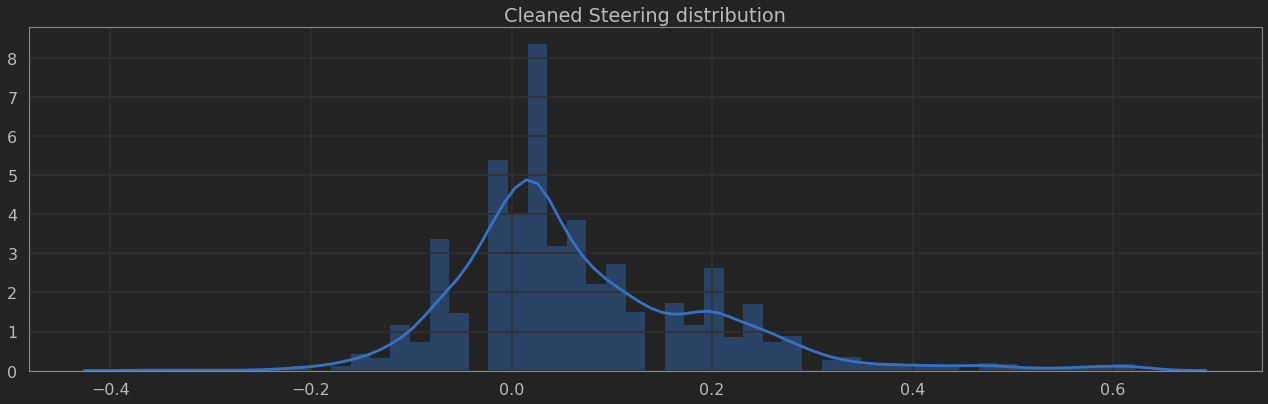

In [53]:
plt.figure(figsize=(18,6))
plt.title("Cleaned Steering distribution")
sns.distplot(yy_train[:,0])
plt.tight_layout()

In [55]:
with open('V79_run_original_warehouse.pkl', 'wb') as f:
    pickle.dump(data, f)